#Hands On Machine Learning Chapter 3
#Classification!

We will use the MNIST dataset!

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np

In [ ]:
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])



1.   DESCR -> dataset description
2.   data -> one row per example and one column per feature
3.   target -> array of labels


In [ ]:
X, y = mnist["data"], mnist["target"]

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

> There are 70,000 images and 784 features as each image is 28x28 pixels grayscale.

> Each pixel has a value between 0 (white) and 255 (black).

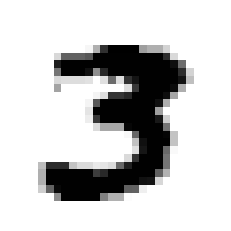

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt


some_digit = X[27]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

That's a 3 if I 'er seen one.

In [ ]:
y[27]

'3'

In [ ]:
y = y.astype(np.uint8)

This MNIST dataset is already split into 60000 (training) and the last 10000(test) images.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier


Let us start with a simpler task of identifying if the digit is 5 or not.

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

First, we will use SGD (Stochastic Gradient Descent) which is capable of handling large data sets and also usable for online learning.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now, let's test it on a digit.

In [ ]:
sgd_clf.predict([some_digit])

array([False])

It predicts a 3 as False! so that's correct :3

# Model Evaluation!

1. Cross Validation

    **split training set into K-folds with 3 parts training and one part test, and compare those results.**

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

**IMPORTANT:** Accuracy is a metric as the ratio of correct predictions.

Results look good, but before we decide that this is the best classifier, let's look a classifier that predicts all images as not-five.

### Dumb classifier

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

wait, what? That's 90% accuracy on a classifier that predicts the same thing EVERYTIME!!!

That's because out of 70000 images, **only 10% images are of 5s** while the others are **not 5s**.

Hence, if you always predicted that an image is **not 5**, you will be right 90% of times.

In [ ]:
class Always5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.ones((len(X), 1), dtype = bool)

In [ ]:
always_5_clf = Always5Classifier()
cross_val_score(always_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.08875, 0.09145, 0.09085])

As expected, ~8-10% accuracy on a classifier that predicts 5 everytime.

So, this is obviously not a good metric to measure classifier.

### Confusion Matrix



*   The number of times class A was classified as class B is at the **Ath row** and **Bth column**!



In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

**cross_val_predict** will perform K-fold cross validation, but instead of returning the scores, it returns the predictions made on each test fold.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

**REMEMBER**: Each row in confusion matrix represents **actual class**. Each column in confusion matrix represents **predicted class**.

In our case, the first row contains non-five images, out of which 53892 were predicted correctly and 687 were predicted as fives.

The second row contains fives, out of which 1891 were predicted wrongly and 3530 were predicted as fives.

##### Some metrics based on confusion matrix:
1. Precision: accuracy of positive predictions. Ratio of instances predicted positively vs. instances falsely predicted positively.
    \begin{align}
    \frac{TP}{TP + FP}
    \end{align}

This is typically used with another metric called **recall** or **sensitivity** or **true positive rate**.
2. Recall: ratio of positive instances correctly detected. Ratio of positive instances predicted positively vs. positive instances predicted negatively.

    \begin{align}
    \frac{TP}{TP + FN}
    \end{align}

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

When our predictor **predicts five**, it is five only 83% of times.

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Our predictor only **predicts 65% of 5s correctly**.

#### F1 Score!

It is the **harmonic mean** of recall and precision.

Regular mean treats all values equally, whereas harmonic mean gives much more weight to **low values** and hence, the score is high only when **recall and precision are both high**.

\begin{align}
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
\end{align}

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

This is a good overall measure, but may not be the best measure in every case.

For example, if you trained a classifier **to detect videos safe for kids**, you would prefer a classifier where **many good videos are rejected** (low recall) but **only safe ones** are kept. (high precision).

On the other hand, suppose you trained a classifier **to detect shoplifters on surveillance images**, you only care about **every shoplifter getting caught** (high recall), and it doesn't matter even if **someone is falsely predicted to be shoplifting** (low precision).

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label = "Recall")
    plt.axis([-50000, 50000, 0, 1])

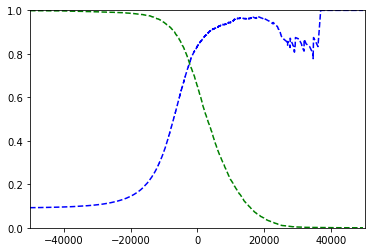

In [47]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Now, suppose we want 90% precision, so we can search for the first index where precision >= 0.90.

Then we can take that corresponding threshold!

In [51]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

Now, we can just use this threshold to get our predictions.

In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

Perfect!

In [45]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

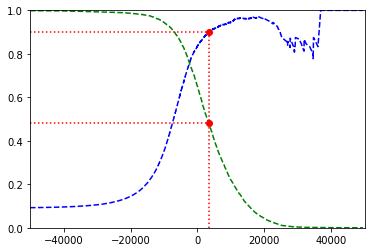

In [54]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  # Line separating area where precision < 90% and >= 90%.
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                 # Same for precision
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # Line for recall
plt.plot([threshold_90_precision], [0.9], "ro") # Intersection point for precision
plt.plot([threshold_90_precision], [recall_90_precision], "ro") # Intersection point for recall
plt.show()